In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [6]:
# Create our features
X = df.drop('loan_status', axis=1)
X=pd.get_dummies(X)

# Create our target
y = df['loan_status']
# Create our target


In [7]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [8]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
Counter(y_train)

Counter({'low_risk': 51366, 'high_risk': 246})

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [22]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
classifier = BalancedRandomForestClassifier(n_estimators=128, random_state=78) 
classifier=classifier.fit(X_train, y_train)
predictions=classifier.predict(X_test)

In [17]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.769767826876233

In [16]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
y_pred=classifier.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[   67    34]
 [ 2118 14986]]


In [18]:
# Print the imbalanced classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.03      0.66      0.06       101
    low_risk       1.00      0.88      0.93     17104

    accuracy                           0.87     17205
   macro avg       0.51      0.77      0.50     17205
weighted avg       0.99      0.87      0.93     17205



In [20]:
# List the features sorted in descending order by feature importance
importances =classifier.feature_importances_
importances

array([1.28935202e-02, 3.07278742e-02, 1.59436511e-02, 1.26916172e-02,
       1.74318714e-02, 4.30076333e-03, 7.43959280e-03, 8.78027675e-03,
       1.85660057e-03, 1.58549258e-02, 1.04168140e-02, 1.85638151e-02,
       1.51731261e-02, 5.43228979e-02, 6.09401002e-02, 7.26284106e-02,
       5.35162259e-02, 8.04443768e-03, 0.00000000e+00, 0.00000000e+00,
       6.25581428e-02, 5.74424889e-04, 0.00000000e+00, 0.00000000e+00,
       5.09620189e-03, 1.13768029e-02, 7.26221045e-03, 6.24322889e-03,
       4.67937629e-03, 7.12142993e-03, 1.70624235e-02, 1.12090073e-02,
       1.32779210e-02, 4.56245389e-03, 4.78686640e-03, 1.53727630e-02,
       1.20515175e-02, 1.42883574e-02, 8.64878395e-03, 7.72271983e-03,
       9.94946070e-03, 1.00708434e-02, 1.42886333e-02, 1.26714485e-02,
       1.27785072e-02, 2.13414351e-04, 0.00000000e+00, 1.56963404e-02,
       1.09743899e-02, 1.01416651e-02, 9.27227234e-03, 5.47974504e-03,
       1.13750957e-02, 1.72838651e-02, 2.65165541e-03, 8.02564264e-03,
      

In [21]:
# We can sort the features by their importance
sorted(zip(classifier.feature_importances_, X.columns), reverse=True)

[(0.07262841061200165, 'total_rec_prncp'),
 (0.06255814279669179, 'last_pymnt_amnt'),
 (0.060940100221837414, 'total_pymnt_inv'),
 (0.05432289788407919, 'total_pymnt'),
 (0.05351622589959488, 'total_rec_int'),
 (0.030727874174785924, 'int_rate'),
 (0.019085827934691553, 'issue_d_Jan-2019'),
 (0.01856381513350686, 'out_prncp'),
 (0.017431871376241914, 'dti'),
 (0.017283865115752507, 'mths_since_recent_inq'),
 (0.017062423500755514, 'mths_since_rcnt_il'),
 (0.016782911459513827, 'tot_hi_cred_lim'),
 (0.016567229862698454, 'issue_d_Mar-2019'),
 (0.01594365109347828, 'installment'),
 (0.015854925842599933, 'revol_bal'),
 (0.015696340366866984, 'mo_sin_old_il_acct'),
 (0.015372762980700306, 'max_bal_bc'),
 (0.015173126063903981, 'out_prncp_inv'),
 (0.014288633338754412, 'avg_cur_bal'),
 (0.014288357396023398, 'total_rev_hi_lim'),
 (0.013277920960103941, 'il_util'),
 (0.012893520168412734, 'loan_amnt'),
 (0.01277850722614497, 'bc_util'),
 (0.012691617205709096, 'annual_inc'),
 (0.01267144846

In [28]:
feature_importance_df = pd.DataFrame({"features": X.columns,
                                     "feature_importance": classifier.feature_importances_})
feature_importance_df = feature_importance_df.sort_values("feature_importance", ascending=False).reset_index(drop=True)
feature_importance_df

,features,feature_importance
0,total_rec_prncp,0.072628
1,last_pymnt_amnt,0.062558
2,total_pymnt_inv,0.060940
3,total_pymnt,0.054323
4,total_rec_int,0.053516
...,...,...
90,acc_now_delinq,0.000000
91,delinq_amnt,0.000000
92,recoveries,0.000000
93,collection_recovery_fee,0.000000


In [30]:
import matplotlib.pyplot as plt

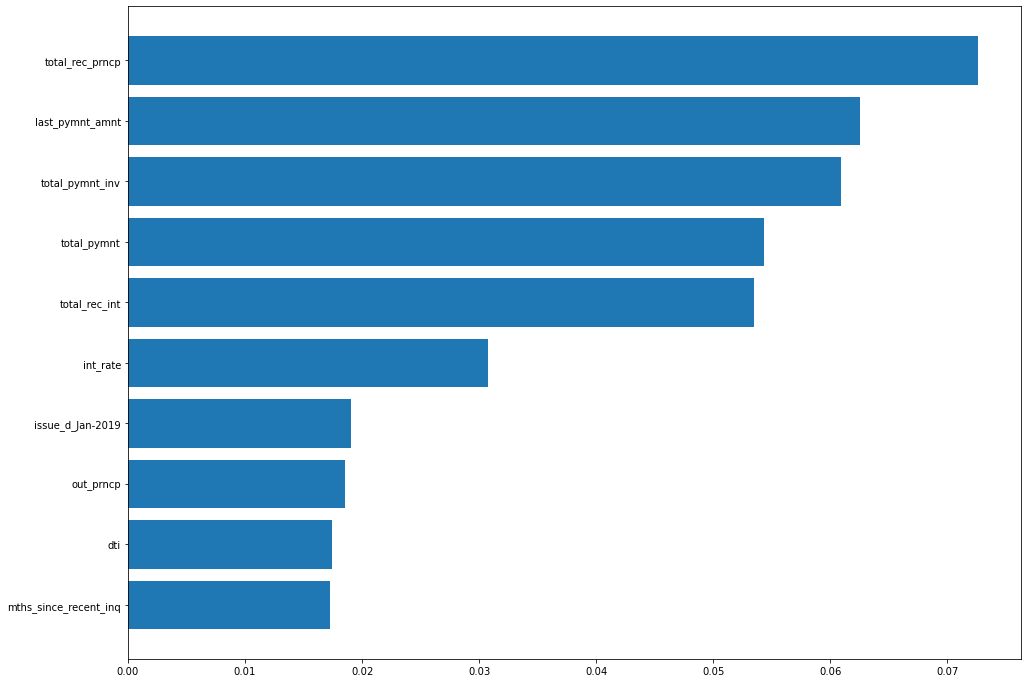

In [34]:
fig,ax = plt.subplots(figsize=(16,12))
ax.barh(feature_importance_df['features'][:10],
       feature_importance_df['feature_importance'][:10])
ax.invert_yaxis()

### Easy Ensemble AdaBoost Classifier

In [23]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
classifier1 = EasyEnsembleClassifier(n_estimators=100, random_state=1) 
classifier1=classifier1.fit(X_train, y_train)
predictions=classifier.predict(X_test)

In [25]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.9316600714093861

In [24]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
y_pred=classifier1.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[   93     8]
 [  983 16121]]


In [26]:
# Print the imbalanced classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.09      0.92      0.16       101
    low_risk       1.00      0.94      0.97     17104

    accuracy                           0.94     17205
   macro avg       0.54      0.93      0.56     17205
weighted avg       0.99      0.94      0.97     17205

